In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
#    dataset_orig = AdultDataset()
    dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        
    for i in range(1000):
        if (dataset_orig.labels[i] == 2.0):
            dataset_orig.labels[i] = 0
        else:
            dataset_orig.labels[i] = 1
        
    dataset_orig.favorable_label = 1
    dataset_orig.unfavorable_label = 0

    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]    

# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
'''fnr for adult, weighted for german to get meaningful results'''
#random seed for calibrated equal odds prediction
randseed = 12345679

In [3]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

scale_orig = StandardScaler()

#Stratified sampling??
X = scale_orig.fit_transform(dataset_orig.features)
y = dataset_orig.labels.ravel()

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
X_1, X_2 = sss.split(X, y)


In [5]:
print(len(X_1[0]))
print(len(X_1[1]))

print(X_1[0][0])

34189
14653
19261


In [6]:
# Logistic regression classifier and predictions for training data

X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression(class_weight= "balanced")
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for testing data
X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

In [7]:
#Performance Metrics of the dataset predictions without post-processing

metric_orig_data_test = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)



classified_orig_data_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_orig_test_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


display(Markdown("#### LR predictions with %s test set fairness performance"%dataset_used))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
eop_aeo = classified_orig_data_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % eop_aeo)

#Disparate Impact ratio between privileged and unprivileged groups.
eop_di = classified_orig_data_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % eop_di)

#Demographic parity difference between privileged and unprivileged groups.
eop_spd = classified_orig_data_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % eop_spd)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
eop_ppd = classified_orig_data_test.positive_predictive_value(privileged=False) - classified_orig_data_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % eop_ppd)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_orig_data_test.consistency())


#Prediction performance metrics
TPR = classified_orig_data_test.true_positive_rate() #recall
TNR = classified_orig_data_test.true_negative_rate() #specificity
PPV =classified_orig_data_test.positive_predictive_value() #precision
bal_acc = (TPR+TNR)/2
f1 = 2*((PPV*TPR)/(PPV+TPR))

display(Markdown("#### LR predictions with %s test set prediction performance" %dataset_used))
print("Standard accuracy of logistic regression trained on test set without any mitigation = %f" %classified_orig_data_test.accuracy())
print("Balanced accuracy of logistic regression trained on test set without any mitigation = %f" % bal_acc)
print("F1 score of logistic regression trained on test set without any mitigation = %f" % f1)

print("Detailed scores for %s dataset"%dataset_used)
print("Precision (PPV): %f" %PPV)
print("Recall (TPR): %f" %TPR)
print("Specificity (TNR): %f" %TNR)

#### LR predictions with adult test set fairness performance

Average equalized odds difference between unprivileged and privileged groups = -0.340446
Disparate impact ratio between unprivileged and privileged groups = 0.270073
Demographic parity difference between unprivileged and privileged groups = -0.380085
Predictive Parity difference between unprivileged and privileged groups = -0.160326


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Consistency of indivuals' predicted labels = 0.999481


#### LR predictions with adult test set prediction performance

Standard accuracy of logistic regression trained on test set without any mitigation = 0.732614
Balanced accuracy of logistic regression trained on test set without any mitigation = 0.744952
F1 score of logistic regression trained on test set without any mitigation = 0.575882
Detailed scores for adult dataset
Precision (PPV): 0.460526
Recall (TPR): 0.768342
Specificity (TNR): 0.721562


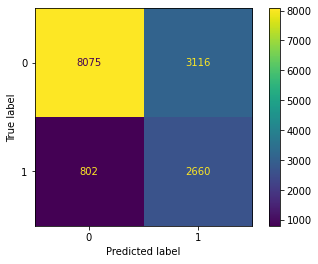

In [8]:
cm_orig = confusion_matrix(dataset_orig_test.labels,dataset_orig_test_pred.labels)

disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig)
disp_orig.plot()

In [9]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_train, dataset_orig_train_pred)

In [10]:
dataset_transf_train_pred = cpp.predict(dataset_orig_train_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [11]:
cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate)) < np.abs(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

In [12]:
#Performance Metrics of the dataset post-processing predictions

metric_trans_data_test = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)



classified_transf_data_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_transf_test_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


display(Markdown("#### Post-processed LR predictions with %s test set fairness performance"%dataset_used))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
eop_aeo_a = classified_transf_data_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % eop_aeo_a)

#Disparate Impact ratio between privileged and unprivileged groups.
eop_di_a = classified_transf_data_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % eop_di_a)

#Demographic parity difference between privileged and unprivileged groups.
eop_spd_a = classified_transf_data_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % eop_spd_a)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
eop_ppd_a = classified_transf_data_test.positive_predictive_value(privileged=False) - classified_transf_data_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % eop_ppd_a)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_trans_data_test.consistency())


#Prediction performance metrics
TPRa = classified_transf_data_test.true_positive_rate() #recall
TNRa = classified_transf_data_test.true_negative_rate() #specificity
PPVa =classified_transf_data_test.positive_predictive_value() #precision
bal_acc_a = (TPRa+TNRa)/2
f1_a = 2*((PPVa*TPRa)/(PPVa+TPRa))

display(Markdown("#### Post-processed LR predictions with %s test set prediction performance" %dataset_used))
print("Standard accuracy of logistic regression trained on test set with post-processing = %f" %classified_transf_data_test.accuracy())
print("Balanced accuracy of logistic regression trained on test set with post-processing = %f" % bal_acc_a)
print("F1 score of logistic regression trained on test set with post-processing = %f" % f1_a)

print("Detailed scores for %s dataset"%dataset_used)
print("Precision (PPV): %f" %PPVa)
print("Recall (TPR): %f" %TPRa)
print("Specificity (TNR): %f" %TNRa)



#### Post-processed LR predictions with adult test set fairness performance

Average equalized odds difference between unprivileged and privileged groups = 0.058552
Disparate impact ratio between unprivileged and privileged groups = 0.786426
Demographic parity difference between unprivileged and privileged groups = -0.038192
Predictive Parity difference between unprivileged and privileged groups = -0.160735


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Consistency of indivuals' predicted labels = 0.839146


#### Post-processed LR predictions with adult test set prediction performance

Standard accuracy of logistic regression trained on test set with post-processing = 0.742032
Balanced accuracy of logistic regression trained on test set with post-processing = 0.591324
F1 score of logistic regression trained on test set with post-processing = 0.358887
Detailed scores for adult dataset
Precision (PPV): 0.434675
Recall (TPR): 0.305604
Specificity (TNR): 0.877044


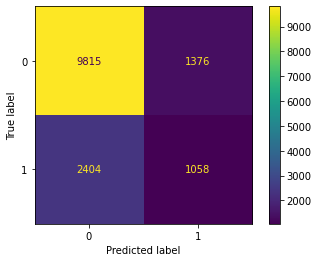

In [13]:
cm_test = confusion_matrix(dataset_orig_test.labels, dataset_transf_test_pred.labels)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

In [14]:
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for test and parameter selection"))

bef_avg_odds_diff_test = []

aft_avg_odds_diff_test = []

bef_bal_acc_test = []

aft_bal_acc_test = []

for thresh in tqdm(all_thresh):    

    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original test data
    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf test data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for test and parameter selection

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.55it/s]


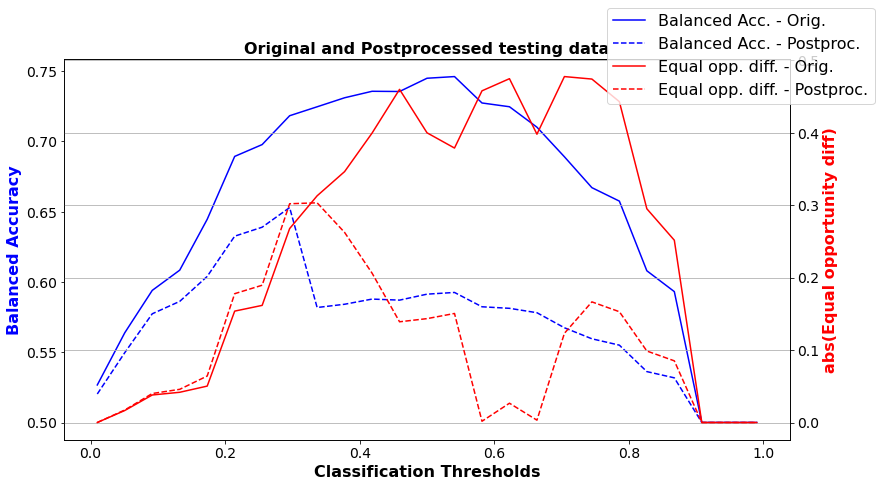

In [15]:
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)